# Assignment 3

#### Download the IRIS dataset from sklearn and use the first two given characteristics in order to classify each sample. Use 50% of the dataset for training purposes and the other half as a test set.

In [4]:
# Run this cell before anything else

from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter

iris = datasets.load_iris()

x = iris.data[:, :2]
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=True)

## Part A

#### Classify each sample using a Decision Tree Classifier. What is the percentage of correct classification? Find the tree depth with the best results.



In [14]:
tree_classifier = DecisionTreeClassifier(criterion="gini")

tree_classifier.fit(x_train, y_train)
depth = tree_classifier.get_depth()

scores = []
depths = [i for i in range(1, depth + 1)]
for i in depths:
    clf = DecisionTreeClassifier(criterion="gini", max_depth=i)
    clf.fit(x_train, y_train)

    prediction = clf.predict(x_test)
    accuracy = accuracy_score(y_true=y_test, y_pred=prediction)

    accuracy = np.around(accuracy * 100, 2)
    scores.append(accuracy)

print(scores)
max_score = np.max(scores)
max_score_index = np.argmax(scores)
best_depth = depths[max_score_index]

print(f"Best tree depth is: {best_depth} with score: {max_score}")

[57.33, 73.33, 76.0, 77.33, 77.33, 77.33, 77.33, 72.0, 70.67, 69.33, 69.33, 69.33, 69.33, 69.33]
Best tree depth is: 4 with score: 77.33


#### Plot the decision boundaries of the classifier for the best tree depth found above

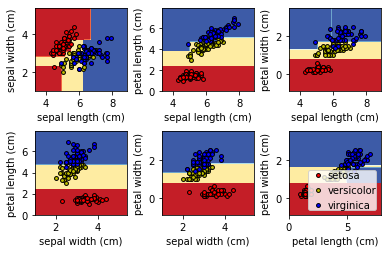

In [15]:
def plot_results(depth, forest=False):
    # Parameters
    n_classes = 3
    plot_colors = "ryb"
    plot_step = 0.02

    for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Train
        if not forest:
            clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
            clf.fit(X, y)
        else:
            clf = RandomForestClassifier(n_estimators=100, bootstrap=True, max_features=gamma, max_depth=best_depth)
            clf.fit(x_train, y_train)

        # Plot the decision boundary
        ax = plt.subplot(2, 3, pairidx + 1)
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
        DecisionBoundaryDisplay.from_estimator(
            clf,
            X,
            cmap=plt.cm.RdYlBu,
            response_method="predict",
            ax=ax,
            xlabel=iris.feature_names[pair[0]],
            ylabel=iris.feature_names[pair[1]],
        )

        # Plot the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(
                X[idx, 0],
                X[idx, 1],
                c=color,
                label=iris.target_names[i],
                cmap=plt.cm.RdYlBu,
                edgecolor="black",
                s=15,
            )

    plt.legend(loc="lower right", borderpad=0, handletextpad=0)
    _ = plt.axis("tight")
    plt.show()


plot_results(best_depth, False)

## Part B

#### Create a Random Forest Classifier of 100 decision trees based on the Bootstrap method. Create 100 new subsets, one for each tree, and each time use 50% of the train set. Each tree shall have the same max depth.
#### What is the percentage of correct classification? Find the tree depth with the best results.


In [16]:
def bootstrap_sample(X, y, gamma):
    n_samples = np.floor(gamma * X.shape[0]).astype(int)
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

class RandomForest:

    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, gamma=1.0):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = []
        self.gamma = gamma

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(min_samples_split=self.min_samples_split,
                                          max_depth=self.max_depth)
            X_samp, y_samp = bootstrap_sample(X, y, self.gamma)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

In [17]:
gamma = 0.5

scores_forest = []
for i in depths:
    #clf = RandomForestClassifier(n_estimators=100, bootstrap=True, max_features=gamma, max_depth=i)
    #clf = RandomForestClassifier(n_estimators=100, bootstrap=True, max_samples=gamma, max_depth=i)
    clf = RandomForest(n_trees=100, gamma=gamma, max_depth=i)
    clf.fit(x_train, y_train)

    prediction = clf.predict(x_test)
    accuracy = accuracy_score(y_true=y_test, y_pred=prediction)

    accuracy = np.around(accuracy * 100, 2)
    scores_forest.append(accuracy)

print(scores_forest)
max_score = np.max(scores_forest)
max_score_index = np.argmax(scores_forest)
best_depth = depths[max_score_index]

print(f"Best tree depth is: {best_depth} with score: {max_score}")

[53.33, 70.67, 77.33, 78.67, 77.33, 77.33, 76.0, 76.0, 76.0, 78.67, 74.67, 74.67, 76.0, 74.67]
Best tree depth is: 4 with score: 78.67


#### Plot decision boundaries of the classifier for the best tree depth found above.


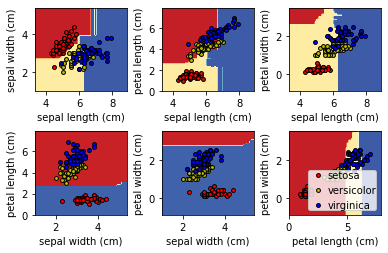

In [18]:
plot_results(best_depth, True)

#### Describe the differences the classifier in Part A.

The Random Forest Classifier achieves higher accuracy than the Decision Tree Classifier in Part A. This is to be expected since a Random Forest Classifier consists of many Decision Trees combined in order to get higher precision than a single Decision Tree. This also means that Random Forest Classifiers are significantly more computationally intensive.

#### How does the gamma parameter affect algorithm precision? Give examples.

We will use `GridSearchCV()` in order to find out how gamma affects the algorithm precision. We will try gamma values from 0.1 to 1.0 with step 0.1.

In [19]:
param_grid = {
    'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

clf = RandomForestClassifier(n_estimators=100, bootstrap=True, max_depth=best_depth)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, verbose=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...................max_samples=0.1;, score=0.800 total time=   0.1s
[CV 2/5] END ...................max_samples=0.1;, score=0.800 total time=   0.1s
[CV 3/5] END ...................max_samples=0.1;, score=0.733 total time=   0.1s
[CV 4/5] END ...................max_samples=0.1;, score=0.667 total time=   0.1s
[CV 5/5] END ...................max_samples=0.1;, score=0.600 total time=   0.1s
[CV 1/5] END ...................max_samples=0.2;, score=0.933 total time=   0.1s
[CV 2/5] END ...................max_samples=0.2;, score=0.800 total time=   0.1s
[CV 3/5] END ...................max_samples=0.2;, score=0.800 total time=   0.1s
[CV 4/5] END ...................max_samples=0.2;, score=0.667 total time=   0.1s
[CV 5/5] END ...................max_samples=0.2;, score=0.600 total time=   0.1s
[CV 1/5] END ...................max_samples=0.3;, score=0.867 total time=   0.1s
[CV 2/5] END ...................max_samples=0.3;

{'max_samples': 0.2}